# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Overall & openSMILE emobase Featureset

## Import relevant libraries

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [22]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [23]:
df_essentia_best_overall_opensmile_emnobase_features = pd.read_csv(get_deam_path('processed/features/integrated/normalised_essentia_best_overall_opensmile_emobase_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_emnobase_features = df_essentia_best_overall_opensmile_emnobase_features[df_essentia_best_overall_opensmile_emnobase_features.columns[1:]]

df_essentia_best_overall_opensmile_emnobase_features

,song_id,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,...,F0env_sma_de_linregerrQ,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3
0,2,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,...,0.427306,0.633121,0.052970,0.008991,0.546204,0.931732,0.403270,0.453796,0.401456,0.428889
1,3,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,...,0.141595,0.340520,0.068615,0.031988,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
2,4,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,...,0.399049,0.609771,0.048627,0.007233,0.706684,0.931732,0.238975,0.293316,0.237900,0.266529
3,5,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,...,0.416902,0.624603,0.046268,0.006583,0.578416,0.931732,0.412816,0.421584,0.410959,0.417262
4,7,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,...,0.291508,0.512783,0.052501,0.011769,0.740093,0.931732,0.256946,0.259907,0.255790,0.258448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,...,0.108314,0.291082,0.272948,0.173102,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1740,1997,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,...,0.023071,0.109289,0.090879,0.028913,0.962139,0.931732,0.000000,0.037861,0.000000,0.019198
1741,1998,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,...,0.139224,0.337426,0.046131,0.017807,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1742,1999,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,...,0.096113,0.271372,0.160770,0.069559,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000


In [24]:
df_essentia_best_overall_opensmile_emnobase_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 1125 columns):
 #     Column                                     Dtype  
---    ------                                     -----  
 0     song_id                                    int64  
 1     lowlevel.melbands_kurtosis.dmean           float64
 2     lowlevel.melbands_kurtosis.dmean2          float64
 3     lowlevel.melbands_kurtosis.dvar            float64
 4     lowlevel.melbands_kurtosis.dvar2           float64
 5     lowlevel.melbands_kurtosis.max             float64
 6     lowlevel.melbands_kurtosis.mean            float64
 7     lowlevel.melbands_kurtosis.median          float64
 8     lowlevel.melbands_kurtosis.min             float64
 9     lowlevel.melbands_kurtosis.stdev           float64
 10    lowlevel.melbands_kurtosis.var             float64
 11    lowlevel.melbands_skewness.dmean           float64
 12    lowlevel.melbands_skewness.dmean2          float64
 13    lowlevel.melba

Join both the featureset and annotation set together

In [25]:
df_essentia_best_overall_opensmile_emobase_whole = pd.merge(df_essentia_best_overall_opensmile_emnobase_features, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_emobase_whole = df_essentia_best_overall_opensmile_emobase_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_emobase_whole

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3,valence_mean_mapped,arousal_mean_mapped
0,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,0.000016,...,0.052970,0.008991,0.546204,0.931732,0.403270,0.453796,0.401456,0.428889,-0.475,-0.500
1,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,0.000035,...,0.068615,0.031988,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,-0.375,-0.425
2,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,0.000004,...,0.048627,0.007233,0.706684,0.931732,0.238975,0.293316,0.237900,0.266529,0.175,0.125
3,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,0.000003,...,0.046268,0.006583,0.578416,0.931732,0.412816,0.421584,0.410959,0.417262,-0.150,0.075
4,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,0.000083,...,0.052501,0.011769,0.740093,0.931732,0.256946,0.259907,0.255790,0.258448,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,0.000001,...,0.272948,0.173102,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,-0.275,0.225
1740,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,0.000002,...,0.090879,0.028913,0.962139,0.931732,0.000000,0.037861,0.000000,0.019198,0.075,-0.275
1741,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,0.000005,...,0.046131,0.017807,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,0.350,0.300
1742,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,0.000003,...,0.160770,0.069559,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [26]:
features = df_essentia_best_overall_opensmile_emnobase_features.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,F0env_sma_de_linregerrQ,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3
0,0.005020,0.004055,1.866850e-06,1.524876e-06,0.001798,0.023745,0.027549,0.131211,0.003891,0.000016,...,0.427306,0.633121,0.052970,0.008991,0.546204,0.931732,0.403270,0.453796,0.401456,0.428889
1,0.009253,0.007287,3.311122e-06,2.524975e-06,0.002593,0.082083,0.140294,0.151787,0.005776,0.000035,...,0.141595,0.340520,0.068615,0.031988,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
2,0.004331,0.003332,9.901372e-07,7.146511e-07,0.000979,0.018062,0.026788,0.102714,0.002002,0.000004,...,0.399049,0.609771,0.048627,0.007233,0.706684,0.931732,0.238975,0.293316,0.237900,0.266529
3,0.003204,0.002534,4.937064e-07,4.159568e-07,0.000692,0.016018,0.024134,0.052080,0.001598,0.000003,...,0.416902,0.624603,0.046268,0.006583,0.578416,0.931732,0.412816,0.421584,0.410959,0.417262
4,0.025812,0.019064,1.650024e-05,1.234842e-05,0.003508,0.107675,0.179964,0.143354,0.008974,0.000083,...,0.291508,0.512783,0.052501,0.011769,0.740093,0.931732,0.256946,0.259907,0.255790,0.258448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.003420,0.002785,5.455507e-07,4.706971e-07,0.000535,0.013781,0.024485,0.111224,0.001102,0.000001,...,0.108314,0.291082,0.272948,0.173102,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1740,0.003040,0.002581,4.429354e-07,4.051469e-07,0.000492,0.012825,0.018914,0.078724,0.001181,0.000002,...,0.023071,0.109289,0.090879,0.028913,0.962139,0.931732,0.000000,0.037861,0.000000,0.019198
1741,0.004671,0.003816,2.087614e-06,1.831211e-06,0.002208,0.016787,0.025345,0.058193,0.002020,0.000005,...,0.139224,0.337426,0.046131,0.017807,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000
1742,0.004212,0.003390,7.172558e-07,5.847591e-07,0.001355,0.022245,0.041198,0.244618,0.001735,0.000003,...,0.096113,0.271372,0.160770,0.069559,1.000000,0.931732,0.000000,0.000000,0.000000,0.000000


In [27]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [29]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [30]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [31]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [32]:
num_epochs = 157

Set a random seed to ensure consistent initial weights of the neural network

In [33]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [34]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [35]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 1124])


Training loop

In [36]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [37]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5746450334035433
Epoch 2, Loss: 0.5715367228690077
Epoch 3, Loss: 0.568723843570422
Epoch 4, Loss: 0.5662034033240844
Epoch 5, Loss: 0.5639657421022336
Epoch 6, Loss: 0.5620144761959939
Epoch 7, Loss: 0.5603495127446635
Epoch 8, Loss: 0.5589520832280581
Epoch 9, Loss: 0.557849468213647
Epoch 10, Loss: 0.5570423216073913
Epoch 11, Loss: 0.5565358916684618
Epoch 12, Loss: 0.5563135089408692
Epoch 13, Loss: 0.5563421687370618
Epoch 14, Loss: 0.5565110172833165
Epoch 15, Loss: 0.5566788242015659
Epoch 16, Loss: 0.5567680882195035
Epoch 17, Loss: 0.556777482190829
Epoch 18, Loss: 0.5567465430427734
Epoch 19, Loss: 0.5567011750065124
Epoch 20, Loss: 0.5566445066082453
Epoch 21, Loss: 0.5565730271369262
Epoch 22, Loss: 0.5564914168769578
Epoch 23, Loss: 0.5564502323531654
Epoch 24, Loss: 0.556406500585168
Epoch 25, Loss: 0.5563592835561056
Epoch 26, Loss: 0.5563191070918575
Epoch 27, Loss: 0.5562729273582215
Epoch 28, Loss: 0.5562343520203035
Epoch 29, Loss: 0.556199497973542

Epoch 55, Loss: 0.512489960734965
Epoch 56, Loss: 0.5067746634369639
Epoch 57, Loss: 0.5015278064458155
Epoch 58, Loss: 0.49911122007237646
Epoch 59, Loss: 0.49757202549587576
Epoch 60, Loss: 0.4946854644704594
Epoch 61, Loss: 0.4910206511489863
Epoch 62, Loss: 0.4873650767609312
Epoch 63, Loss: 0.4851739508552587
Epoch 64, Loss: 0.48385790942181356
Epoch 65, Loss: 0.4817848633106549
Epoch 66, Loss: 0.47921724847210706
Epoch 67, Loss: 0.4775466294264445
Epoch 68, Loss: 0.47631626333990706
Epoch 69, Loss: 0.4752886271704639
Epoch 70, Loss: 0.47492148101735077
Epoch 71, Loss: 0.4743722707999104
Epoch 72, Loss: 0.47297657602550575
Epoch 73, Loss: 0.4714483005531081
Epoch 74, Loss: 0.47152151294954175
Epoch 75, Loss: 0.47185189398979355
Epoch 76, Loss: 0.4708703246678204
Epoch 77, Loss: 0.46978887830641225
Epoch 78, Loss: 0.4699105994694321
Epoch 79, Loss: 0.4700158352669895
Epoch 80, Loss: 0.46908940107858094
Epoch 81, Loss: 0.4679695626126018
Epoch 82, Loss: 0.46778533538149547
Epoch 83,

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [38]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 1124])


Generating scores

In [39]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  # metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  # metric.update(test_pred, target_test_labels)
  # adjusted_r2_score = metric.compute()
  # print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [40]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.2029850378970027
Valence RMSE: 0.1882725399978853
Arousal RMSE: 0.2167009503967159
Test R^2 score: tensor([0.5704, 0.5350], dtype=torch.float64)
Test R^2 score (overall): 0.5527237125409493


In [41]:
torch.save(model.state_dict(), '../../models/deam_feedforward_nn_essentia_best_overall_opensmile_emobase_normalised.pt')

True values (test set)

In [21]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [22]:
test_pred

tensor([[ 2.2970e-02, -1.9066e-02],
        [-3.2469e-01, -3.5401e-01],
        [ 2.3141e-02, -1.8568e-02],
        [ 2.3107e-02, -1.8782e-02],
        [-2.8362e-02, -6.5895e-02],
        [-2.2796e-01, -2.5084e-01],
        [-4.9962e-01, -5.4406e-01],
        [ 2.3166e-02, -1.8643e-02],
        [-2.9738e-01, -3.2467e-01],
        [ 2.3150e-02, -1.8592e-02],
        [ 2.3124e-02, -1.8716e-02],
        [-7.4875e-03, -4.7453e-02],
        [-3.6687e-01, -4.0015e-01],
        [ 2.3148e-02, -1.8631e-02],
        [ 1.9762e-02, -2.2687e-02],
        [-2.5819e-01, -2.8247e-01],
        [-5.3937e-01, -5.8748e-01],
        [ 1.2540e-02, -2.9661e-02],
        [ 2.3160e-02, -1.8607e-02],
        [-7.8467e-02, -1.1110e-01],
        [-4.2613e-01, -4.6416e-01],
        [-5.3008e-02, -8.8263e-02],
        [-3.2782e-01, -3.5745e-01],
        [ 2.2955e-02, -1.9081e-02],
        [ 2.3181e-02, -1.8618e-02],
        [ 2.3091e-02, -1.8805e-02],
        [ 2.3153e-02, -1.8618e-02],
        [ 2.3169e-02, -1.860

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [23]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [24]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5746450334035433
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3275871324205851
Test R^2 score: -0.1700001869073665
Num of epochs: 2
Epoch 1, Loss: 0.5746450334035433
Epoch 2, Loss: 0.5715367228690077
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3237414455694503
Test R^2 score: -0.1424245115660614
Num of epochs: 3
Epoch 1, Loss: 0.5746450334035433
Epoch 2, Loss: 0.5715367228690077
Epoch 3, Loss: 0.568723843570422
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3202369261768672
Test R^2 score: -0.11759274216462934
Num of epochs: 4
Epoch 1, Loss: 0.5746450334035433
Epoch 2, Loss: 0.5715367228690077
Epoch 3, Loss: 0.568723843570422
Epoch 4, Loss: 0.5662034033240844
Training completed.
Training completed.
Testing model...
Test RMSE: 0.3170576251644705
Test R^2 score: -0.09534284228933132
Num of epochs: 5
Epoch 1, Loss: 0.5746450334035433
Epoch 2, Loss: 0.5715367228690077
Epoch 3, Loss: 

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [25]:
import matplotlib.pyplot as plt

In [26]:
r2_scores_list

[-0.1700001869073665,
 -0.1424245115660614,
 -0.11759274216462934,
 -0.09534284228933132,
 -0.07559009845094455,
 -0.05822318435063145,
 -0.043030230212775744,
 -0.030212756981492728,
 -0.019711210909134858,
 -0.011503706030553396,
 -0.00541616228436459,
 -0.001969448724638667,
 -0.00031094223058325543,
 0.00023350835347557553,
 0.00027466840693546324,
 0.00011411099107933032,
 -0.0002637878606110422,
 -0.000830523693997054,
 -0.0015289259106820996,
 -0.0022553741143767625,
 -0.0028761027503560466,
 -0.0036976516001974713,
 -0.004375219054210733,
 -0.004860354954552171,
 -0.005213458525565762,
 -0.005367820905556209,
 -0.005438372187367202,
 -0.005442241328407538,
 -0.005356349345031708,
 -0.005206739435550278,
 -0.004995800282604934,
 -0.004687301425359447,
 -0.004234593881606075,
 -0.0038650727279878616,
 -0.003319320682360405,
 -0.0027266724092485095,
 -0.0019773434627214925,
 -0.000853282106687836,
 0.0007275035228641036,
 0.002986904738824292,
 0.006105249414737723,
 0.01047710493

Plot the line graph

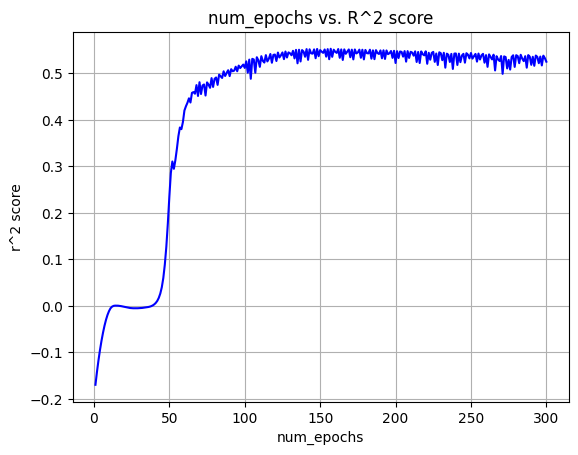

In [27]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [28]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5527237125409493
Corresponding RMSE: 0.2029850378970027
Corresponding num_epochs: 157
